# Pytorch 手写字体训练与检测  --  Mnist

In [1]:
#导入
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable    #自动求导的类

In [2]:
#超参数配置
batch_size=64  #单次训练导入数据个数
test_batch_size=1000
epochs=10  #训练时,每张图片训练次数
lr=0.01   #学习率
momentum=0.5    #动量
no_cuda=False    #是否使用GPU, False表示使用
seed=1
log_interval=10
cuda = not no_cuda and torch.cuda.is_available()  #当no_cuda=False并且cuda可用时使用GPU

#设置随机种子, 保证训练时初始化参数一值, 用以作对比
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    
#下载 训练以及检测数据
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

Processing...
Done!


In [3]:
#构造网络结构, 可以看到构造了2个隐层
#
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)    # 卷积层, 1为输入的channel, 10为输出的channel, 5为卷积核大小(5*5的卷积核)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)    # 卷积层, 10为输入的channel, 20为输出的channel, 5为卷积核大小(5*5的卷积核)
        self.conv2_drop = nn.Dropout2d()    # Dropout层 
        self.fc1 = nn.Linear(320, 50)  #线性函数,输入大小为320个神经元, 输出为50个神经元
        self.fc2 = nn.Linear(50, 10)

    #前向传播过程
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

## 对forward的相关解释:
(1)  x = F.relu(F.max_pool2d(self.conv1(x), 2))

该操作拆开来包含三个基本操作:

    1).  self.conv1(x) : 对输入的x做卷积操作,卷积大小为之前定义的 self.conv1

    2).  F.max_pool2d() : max pooling操作 参数2表示 filter size

    3).  F.relu() : relu函数, 用以非线性化 (备注 relu(x) = max( x , 0) )
    
(2)  x.view(-1, 320) 

    类似reshape操作, 将第二维度转化为320, 第一维随之变化

In [4]:
#训练与检测的函数定义
#在后面会详细分析
model = Net()
if cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [5]:
#训练与检测过程

for epoch in range(1, epochs + 1):
    train(epoch)
    test()
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.390087
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.350225
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.288934
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.279396
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.272692
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.279640
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.276944
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.233707
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.222649
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.181699
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.159016
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.055779
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.065889
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.916480
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.910268
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.704504
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.554525
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.621117
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.521305
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.533543
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.460257
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.383947
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.446170
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.270974
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.176238
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.366832
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.305981
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.437950
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.441521
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.382037
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.314038
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.313957
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.243404
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.382839
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.227108
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.323998
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.594506
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.353640
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.567365
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.513594


Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.312022
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.248610
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.189675
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.360281
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.312034
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.204554
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.420910
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.269933
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.140063
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.211283
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.308067
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.139301
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.317885
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.371763
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.245708
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.135173
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.212181
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.418540
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.098431
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.084603


Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.363544
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.145745
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.156219
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.319050
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.380941
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.272696
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.187006
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.113817
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.165745
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.299145
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.264856
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.352371
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.261457
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.283135
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.166152
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.137011
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.491373
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.175530
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.255817
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.186823


Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.411357
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.160009
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.108378
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.315160

Test set: Average loss: 0.0675, Accuracy: 9767/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.425770
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.158569
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.188077
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.294055
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.201091
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.342126
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.344117
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.195364
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.252965
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.408598
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.116551
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.184732
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.233030
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.195725
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.112294
Train Epoch: 8 [9

Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.210587
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.201186
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.145674
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.080825
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.354076
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.091128
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.285766
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.155581
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.300247
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.086452
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.205141
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.056156
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.162006
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.301807
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.235189
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.094852
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.157344
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.091938
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.271281
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.192830


In [10]:
# 模型的保存 与导入
#方式一: 保存model结构以及全部参数
torch.save(model, './model.pkl')
model_load = torch.load('./model.pkl')

#方式二: 仅保存参数
torch.save(model.state_dict(), './model_state.pkl')
model_load_1 = Net() #初始化模型结构
model_load_1.load_state_dict(torch.load('./model_state.pkl'))

## 以上即为整个网络的结构以及相应的训练与检测过程

## 接下来对网络结构进行进一步详细分析

    (1). 网络结构中包含两部分主要数据: data 以及 weight , 训练过程就是对输入的data 找到最合适的weight, 使得输出最能代表data的属性特征.

    (2). data由原始数据而来, 一般而言可以分为train(训练集), val(验证集), test(测试集)

    (3). 每一层的输出称为 feature map(特征图)

    (4). 一般而言, cnn网络的浅层特征图可以包含更多局部信息, 而深层特征图包含更多全局信息.

#### 第一, 本网络中 weight 结构的相关分析 :

In [6]:
#打印所定义的model
print( model)
# 可以看到定义的基本网络结构包含conv1,conv2,conv2_drop,fc1,fc2这几个基本单元

Net (
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d (p=0.5)
  (fc1): Linear (320 -> 50)
  (fc2): Linear (50 -> 10)
)


In [7]:
#详细打印所定义的卷积层 conv1
print( model.conv1)    #打印卷积核的整体参数
print( model.conv1.in_channels)    #打印输入通道数
print( model.conv1.out_channels)    #打印输出通道数
print( model.conv1.kernel_size)    #打印卷积核kernel_size大小
print( model.conv1.padding)    #打印卷积核padding大小

# 解释:卷积大小 5x5x1x10 (10个5x5x1大小的卷积核, 其中1为上一层feature map层数)
# 对于输入为28x28x1的图片, 经过该卷积, 输出为24x24x10
# 并且可见当未对 stride(步长) 以及 padding(补偿) 进行定义时, 默认 stride = 1, padding = 0

Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
1
10
(5, 5)
(0, 0)


In [8]:
#卷积层weight 的分析
#(1).打印随机初始化的卷积核参数 (不存在seed)
model = Net()
if cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

print( model.conv1.weight) 


Parameter containing:
(0 ,0 ,.,.) = 
  0.0718 -0.0599  0.0084  0.1853 -0.0768
  0.1293 -0.1749  0.0592  0.0821  0.1828
  0.1663  0.1243 -0.0504  0.1141  0.1300
 -0.1124  0.0702  0.1318  0.1578  0.0617
 -0.0682  0.1047  0.0271 -0.1189 -0.1897

(1 ,0 ,.,.) = 
  0.0904 -0.0637  0.1429  0.0290 -0.0554
  0.0337  0.0381  0.0624 -0.1583 -0.0627
  0.1891 -0.0269 -0.0208 -0.0912  0.0931
  0.1318  0.0365 -0.0591 -0.0320  0.0291
  0.0797 -0.1200  0.1113 -0.1570  0.0432

(2 ,0 ,.,.) = 
 -0.1496 -0.1100  0.1010 -0.0170 -0.0978
  0.0173 -0.0529  0.0389  0.1086 -0.1525
  0.0892  0.1002  0.0454  0.1093 -0.1228
 -0.0084  0.0033 -0.0241 -0.0512 -0.1507
 -0.0800  0.0008 -0.1261 -0.1517  0.0656

(3 ,0 ,.,.) = 
 -0.1841  0.1774 -0.1910 -0.1493  0.1080
 -0.1123 -0.0688 -0.1626 -0.0138  0.0164
 -0.0535 -0.1626  0.0468 -0.1920  0.1368
  0.1302 -0.1057 -0.0190 -0.0736 -0.1097
 -0.0977 -0.0791  0.0472  0.0167  0.1136

(4 ,0 ,.,.) = 
 -0.1334 -0.1217  0.1484  0.0244 -0.0805
 -0.1413 -0.1151 -0.1964 -0.1658  0.11

In [6]:
#卷积层weight 的分析
#(2).打印随机初始化的卷积核参数 (使用固定seed)
seed=1
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    
model = Net()
if cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

print( model.conv1.weight) 

Parameter containing:
(0 ,0 ,.,.) = 
 -0.0332  0.1989  0.0881  0.1730 -0.2000
 -0.1488 -0.0791  0.1996 -0.1413 -0.1056
 -0.1631 -0.0414 -0.1255 -0.0448 -0.0618
  0.0679 -0.0413  0.1742  0.0155  0.1385
 -0.0323 -0.0747  0.0741  0.0098 -0.1182

(1 ,0 ,.,.) = 
 -0.0226  0.1512 -0.1082 -0.1890  0.0138
  0.0682  0.1656 -0.0331 -0.0171  0.0235
 -0.0277 -0.1438  0.1757 -0.1208  0.1114
  0.1203  0.0864  0.1873  0.1211 -0.0746
 -0.1629  0.0769  0.0073  0.1506  0.1460

(2 ,0 ,.,.) = 
  0.1578  0.1317 -0.1660  0.1318 -0.1844
 -0.0908 -0.1321 -0.1763  0.1513  0.0682
 -0.1607  0.0372 -0.0316  0.0687  0.1832
 -0.0353  0.0133 -0.1210  0.0768 -0.0841
 -0.0738 -0.1432  0.0746  0.1133  0.1339

(3 ,0 ,.,.) = 
 -0.0350 -0.1927 -0.1863  0.1001  0.0496
  0.1955  0.0643  0.0993 -0.0806 -0.0878
 -0.0215  0.1157 -0.1112 -0.1587 -0.1707
 -0.0208 -0.0123  0.1634 -0.1615 -0.0826
  0.1613 -0.0849 -0.1522 -0.1480  0.0099

(4 ,0 ,.,.) = 
 -0.1923 -0.1666  0.0715  0.1667 -0.1153
  0.1642 -0.0938 -0.0804 -0.0034  0.03

In [10]:
#卷积层weight 的分析
#(3).经过一轮训练之后的卷积参数
for epoch in range(1, 1 + 1):
    train(epoch)
    
print( model.conv1.weight) 

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.390087
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.350225
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.288934
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.279396
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.272692
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.279640
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.276944
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.233707
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.222649
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.181699
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.159016
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.055780
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.065890
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.916481
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.910268
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.704504
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.554525
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.621117
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.521305
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.533543
Train Epoch: 1 [12800/60000 (

#### 卷积weight分析总结:
   (1). seed可以使得每次初始化的值固定,这样在做实验的时候可以对比,大家的初始化参数都是一样的;

   (2). 在实际项目中一般不需要加seed;
   
   (3). 这里也可以再次看到conv的参数个数为 10x1x5x5 (10为输出的卷积个数, 1为上层feature map 层数, 5x5为卷积核大小);
    
   (4). 可以发现每次train之后,更新的参数是conv的参数, 这里我们可以这样理解: train的过程就是为了找到合适的卷积核参数, 使得对于输入的data, 可以有效的提取特征, 进而根据所提取的特征作进一步的工作, 比如分类.

In [11]:
#  dropout分析
#  可见默认值为 p = 0.5 , 这里p表示随机失活神经元概率, 即0.5的神经元在单次传播过程中不进行梯度更新.

print(model.conv2_drop)
print(model.conv2_drop.p)

Dropout2d (p=0.5)
0.5


In [12]:
# 线性函数,可以等价于全连接
# 参数包括 weight, bias 即权重和偏置(权重系数以及常数项系数)

print(model.fc1)
print(model.fc1.in_features)    #输入的神经元个数
print(model.fc1.out_features)    #输出的神经元个数

#若想打印参数信息, 如下:
# print(model.fc1.weight)
# print(model.fc1.bias)

Linear (320 -> 50)
320
50


#### 第二, 本网络中 data 结构的相关分析 :

In [30]:
# 对原始下载的train data 进行分析

print(train_loader.dataset)    #输入网络的train data (经过了数据转换, 归一化之后的)
print(len(train_loader.dataset))    # train data 图片张数
print(train_loader.dataset[0])    # 该输出的为 转化后的第一张图片的数字结构
print(train_loader.dataset.train_data[0])   #该输出的为 变回原始输入的第一张图片的数字结构
print(train_loader.dataset.train_data[0].type) #该输出的为 变回原始输入的第一张图片的数据类型, 数据类型为torch.ByteTensor 张量
print(train_loader.dataset.train_data[0].shape)  #图像大小为1x28x28


60000
(
(0 ,.,.) = 

Columns 0 to 8 
  -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.0424
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242  0.1995  2.6051
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.1951  2.3633
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242  0.5940
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4


(  0  ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0

(  1  ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0

(  2  ,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
 ...  

(59997,.,.) = 
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    

#### 1. 可以看到对于输入到model中进行训练的数据有如下特点:

(1).输入数据维度为(60000,1,28,28) 即60000张图片, 每张图片为单通道灰度图, 长和宽均为28

(2).输入数据的数据类型为 归一化的float tensor (torch.FloatTensor )

(3).可以通过 transforms 对数据类型进行转换

(4).可以通过train_loader.dataset.train_data直接得到原始图像归一化前的张量数据结构

#### 2. 我们知道这里数据类型是 Tensor 张量, 如果需要以图片形式输出可以有如下几种方式:
    
(1).使用 " .numpy()" 将 Tensor类型  转换为 numpy, 然后使用 opencv 或 matplotlib 作图;
    
(2).使用transforms.ToPILImage() 将 Tensor类型 转化为 PIL类型输出;
    
(3).使用visdom工具, 直接对 Tensor 做可视化 (尝试失败,不想研究,感兴趣可以自己研究下).

(4).其他,例如使用TensorFlow的可视化工具

#### 下面选取了第一种方式进行作图, 其他方式感兴趣可以自己尝试

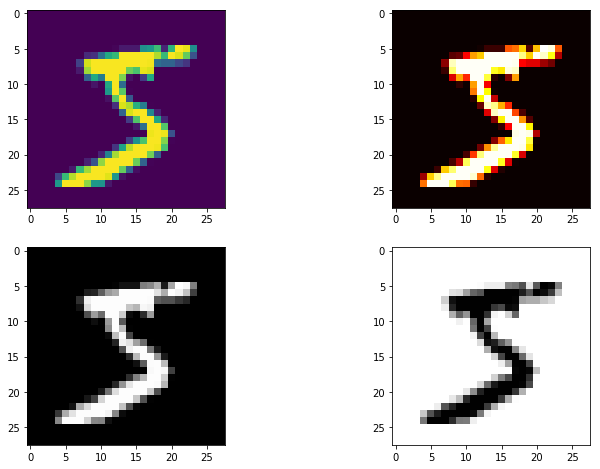

In [16]:
# 原始图像可视化输出 : 使用 opencv 或 matplotlib 作图

import numpy as np    #导入numpy
img_tensor = train_loader.dataset.train_data[0] #导入tensor 数据
img_np = img_tensor.numpy()  #将tensor 数据 转化为numpy

# #下面几行代码使用opencv画图, 不建议在jupyter notebook内使用, 因为cv2.waitKey() 会导致后面程序无法正常运行  
# import cv2    #导入opencv
# cv2.imshow("image", img_np)
# cv2.waitKey()  

#使用matplotlib 作图, 在jupyter notebook中推荐
import  matplotlib.pyplot as plt    #导入matplotlib画图工具
#plt图像嵌入jupyter内
%matplotlib inline 

fig = plt.figure()  
fig.set_size_inches(12, 8)

# 图1: 输出原图
ax1 = fig.add_subplot(221) 
ax1.imshow(img_np)  

# 图2: 输出热力图
ax2 = fig.add_subplot(222) 
ax2.imshow(img_np,  cmap="hot" )  

# 图3: 输出灰度图
ax3 = fig.add_subplot(223) 
ax3.imshow(img_np, cmap=plt.cm.gray)  

# 图4: 输出反向灰度图
ax4 = fig.add_subplot(224) 
ax4.imshow(img_np, cmap=plt.cm.gray_r)  

plt.show() 

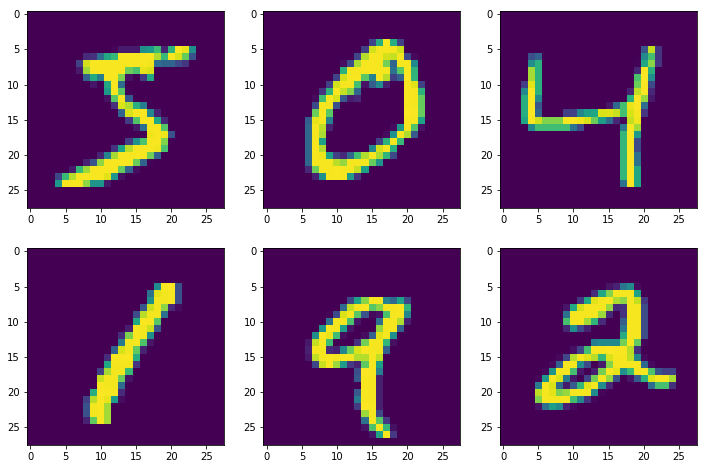

In [20]:
#输出 前6张图
fig = plt.figure()  
fig.set_size_inches(12, 8)

num =231
for i in range(6):
    img_tensor = train_loader.dataset.train_data[i] #导入tensor 数据
    img_np = img_tensor.numpy()  #将tensor 数据 转化为numpy
    ax1 = fig.add_subplot(num) 
    ax1.imshow(img_np)  
    num += 1
plt.show() 


### 下面, 我们展示一下网络的详细训练过程

#### 在此, 我将展示这个网络每一步前向传播中feature map发生的变化, 以及反向传播的weight发生的变化

In [89]:
#初始化 model
model = Net()
if cuda:
    model.cuda()

#选择优化方式, 这里使用的是SGD随机梯度下降, 当然也可以选择别的
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

#导入 train数据
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=False, **kwargs)


In [90]:
#第一个batch的一次前向传播以及反向传播

#以比较愚蠢的方式导入一个batch的数据, 这里一个batch包含64张图
model.train()
for batch_idx, (data_i, target_i) in enumerate(train_loader):
    if batch_idx !=0:
        break
    data, target = data_i.cuda(), target_i.cuda()
print ("一个batch的图片总个数:" )
print (len(data))
print ("这个batch图片的类别信息:" )
print ([j for j in target])

#转换数据类型
data, target = Variable(data), Variable(target)


一个batch的图片总个数:
64
这个batch图片的类别信息:
[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0]


#### 整体流程
在此, 我将展示这个前向传播以及反向传播过程中, 参数是如何变化的

In [91]:
# 预先记录前向传播前的参数大小(以conv1的weiht为例)
print("前向传播前, conv1的参数大小: ")
print(model.conv1.weight) 
print("前向传播前, conv1的梯度大小: ")
print(model.conv1.weight.grad)

#初始化梯度
optimizer.zero_grad()  # zero the gradient buffers，必须要置零

#前向传播
output = model(data)   #前向传播的输出结果, 是一个 64x10的结果, 其中64表示batch_size,10为类别数
print("输出前向传播的输出结果:")
print(output)

#计算loss
loss = F.nll_loss(output, target)    # 计算本次前向传波的loss值
print("输出本次前向传波的loss值:")
print(loss)

#再次打印前向传播后,参数大小
print("前向传播后反向传播前, conv1的参数大小: ")
print(model.conv1.weight) 
print("前向传播后反向传播前, conv1的梯度大小: ")
print(model.conv1.weight.grad)

#反向传播
loss.backward()    # loss的反向传播

#再次打印前向传播后,参数大小
print("反向传播后参数更新前, conv1的参数大小: ")
print(model.conv1.weight) 
print("反向传播后参数更新前, conv1的梯度大小: ")
print(model.conv1.weight.grad)

#参数更新
optimizer.step()

#再次打印前向传播后,参数大小
print("参数更新后, conv1的参数大小: ")
print(model.conv1.weight) 


前向传播前, conv1的参数大小: 
Parameter containing:
(0 ,0 ,.,.) = 
  0.0056  0.1407 -0.0253  0.1999 -0.1994
 -0.1119  0.1906 -0.1263  0.0701 -0.1803
 -0.0821  0.1815  0.0779  0.1674 -0.1716
  0.0052 -0.0165  0.1201 -0.1538  0.0174
 -0.1872  0.0380 -0.0292 -0.0318 -0.1778

(1 ,0 ,.,.) = 
 -0.1960 -0.1326  0.0846 -0.1297  0.0142
  0.1144  0.0488 -0.1724  0.1641  0.0055
 -0.0211  0.1503 -0.0945  0.1493 -0.0684
  0.0383 -0.0214  0.0342  0.0387  0.0328
 -0.0773  0.0035 -0.0590  0.0112  0.1879

(2 ,0 ,.,.) = 
  0.1999  0.1026 -0.1491 -0.0924 -0.1258
  0.0420  0.0497  0.1619 -0.0237  0.1122
  0.1907  0.1579  0.0430 -0.1519  0.1576
 -0.0566  0.1748 -0.1697  0.1135 -0.1544
  0.1580  0.1302  0.1174 -0.1951  0.0236

(3 ,0 ,.,.) = 
 -0.1319 -0.1651  0.1064  0.1096 -0.0925
 -0.0695  0.1518 -0.1159 -0.0858  0.0017
 -0.1722 -0.1757 -0.0232  0.0240  0.1866
  0.0097  0.0489 -0.1157  0.0142 -0.1830
 -0.0899  0.1399 -0.1802 -0.0496  0.1484

(4 ,0 ,.,.) = 
  0.0826 -0.0188  0.0553 -0.0241  0.1129
  0.1193 -0.0050  

### 训练过程详细分析
(1). 前向传播的目的是为了通过网络计算出最终的预测结果, 
再通过损失函数计算出预测值与真实值之间的偏差,即loss, 
将loss值极小化作为优化目标, 极小化预测值与真实值之间的差别.

(2). 优化的方式就是通过计算梯度, 来更新参数包括所有的weight, bias. 
进而使得对于输入的data都可以准确的预测其结果.

(3).于是反向传播的过程也就是根据loss计算相关参数的grad, 计算方式采用的是连式法则.

(4).在计算完各层参数的grad之后,对参数进行更新,
这个更新后的参数,可以使得通过网络得到的预测结果与真实结果之间的差异变小,达到优化的目的.

(5). 而在pytorch代码层面上, 可以发现weight的更新时发生在optimizer.step() (即参数更新指令)之后的, 
而梯度生成时发生在loss.backward() (反向传播)之后的, 
并且梯度是单次有效的,每次前向传播,反向传播后的梯度都是根据本次loss计算出来的,
因此在进行前向传播之前,要将梯度初始化.

#### 当然, 感兴趣的话还可以打印每次卷积前后data发生的变化,这对于理解卷积过程也是有所帮助的, 这部分内容我将放在后面检测过程中的单步结果中讲.

### 下面, 我们展示一下网络的详细检测过程

In [40]:
#导入训练好的模型
model = torch.load('./model.pkl')

#导入测试数据,这里batch_size=1, shuffle=False,保证了每次检测都是单张图片, 并且每次导入的顺序也是固定的
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1, shuffle=False, **kwargs)

model.eval()
print(len(test_loader)) #可见一共有10000张图片
print(type(test_loader))  #打印测试数据的数据类型


10000
<class 'torch.utils.data.dataloader.DataLoader'>


In [69]:
#以比较蠢的方式选取第一张图片数据
i = 1
for data_i, target_i in test_loader:
    if i !=1 :
        break
    data, target = data_i.cuda(), target_i.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    i+=1

#如下两种方式得到,softmax结果:
output = model(data)
print("==== 1 ====.", output) 

output = model.forward(data)
print("==== 2 ====", output) 

#对比检测结果与真实结果: (softmax最大的值对应的index对应的label即为检测结果)
pred = output.data.max(1, keepdim=True)[1] 
print("==== 3 ==== 检测结果为: \t {}".format(pred))
print("==== 4 ==== 真实结果为: \t {}".format(target))

#print(output.data.max(1, keepdim=True))
# 可见检测结果是正确的

==== 1 ====. Variable containing:

Columns 0 to 5 
-2.3931e+01 -2.0862e+01 -1.5924e+01 -1.4905e+01 -2.4521e+01 -2.7253e+01

Columns 6 to 9 
-4.1199e+01 -1.9073e-06 -1.9175e+01 -1.4312e+01
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

==== 2 ==== Variable containing:

Columns 0 to 5 
-2.3931e+01 -2.0862e+01 -1.5924e+01 -1.4905e+01 -2.4521e+01 -2.7253e+01

Columns 6 to 9 
-4.1199e+01 -1.9073e-06 -1.9175e+01 -1.4312e+01
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

==== 3 ==== 检测结果为: 	 
 7
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

==== 4 ==== 真实结果为: 	 Variable containing:
 7
[torch.cuda.LongTensor of size 1 (GPU 0)]



### 检测过程详细分析

(1). 检测就是一个前向传播的过程, 将通过卷积,全连最终接得到feature map, 通过softmax进行分类.

(2). pytorch代码上, 可以发现model() 和 model,forward() 都可以得到结果.

(3). 对于softmax的原理, 可以看机器学习相关资料, 这里不再展开.


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)    # 卷积层, 1为输入的channel, 10为输出的channel, 5为卷积核大小(5*5的卷积核)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)    # 卷积层, 10为输入的channel, 20为输出的channel, 5为卷积核大小(5*5的卷积核)
        self.conv2_drop = nn.Dropout2d()    # Dropout层 
        self.fc1 = nn.Linear(320, 50)  #线性函数,输入大小为320个神经元, 输出为50个神经元
        self.fc2 = nn.Linear(50, 10)

    #前向传播过程
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
#导入训练好的模型
model = torch.load('./model.pkl')

#导入测试数据,这里batch_size=1, shuffle=False,保证了每次检测都是单张图片, 并且每次导入的顺序也是固定的
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1, shuffle=False, **kwargs)

model.eval()
print(len(test_loader)) #可见一共有10000张图片
print(type(test_loader))  #打印测试数据的数据类型
print(target)  #打印真实label,可见这张图是7

i = 1
for data_i, target_i in test_loader:
    if i !=1 :
        break
    data, target = data_i.cuda(), target_i.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    i+=1

data_ori = data
print("原始输入图片的数字结构:")
print(data_ori)

print("========================================")
data_1 = model.conv1(data_ori)
print("经过conv1后的数字结构:")
print(model.conv1.weight)
print("经过conv1后的数字结构:")
print(data_1)

print("========================================")
data_2 = F.max_pool2d(data_1, 2)
print("经过conv1的数字结构:")
print(data_2)

In [7]:
#导入训练好的模型
model = torch.load('./model.pkl')

#导入测试数据,这里batch_size=1, shuffle=False,保证了每次检测都是单张图片, 并且每次导入的顺序也是固定的
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1, shuffle=False, **kwargs)

model.eval()
print(len(test_loader)) #可见一共有10000张图片
print(type(test_loader))  #打印测试数据的数据类型

i = 1
for data_i, target_i in test_loader:
    if i !=1 :
        break
    data, target = data_i.cuda(), target_i.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    i+=1

print(target)  #打印真实label,可见这张图是7

data_ori = data
print("原始输入图片的数字结构:")
print(data_ori)

print("========================================")
print("conv1卷积核参数:")
print(model.conv1.weight)
print("conv1偏置项参数:")
print(model.conv1.bias)
data_1 = model.conv1(data_ori)
print("经过conv1后的数字结构:")
print(data_1)

print("========================================")
data_2 = F.max_pool2d(data_1, 2)
print("经过conv1的数字结构:")
print(data_2)

10000
<class 'torch.utils.data.dataloader.DataLoader'>
Variable containing:
 7
[torch.cuda.LongTensor of size 1 (GPU 0)]

原始输入图片的数字结构:
Variable containing:
(0 ,0 ,.,.) = 

Columns 0 to 8 
  -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242  0.6450  1.9305  1.5996
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242  2.4015  2.8088  2.8088
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242  0.4286  1.0268  0.4922
 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
 -0.4242

（1）这里原始输入data_ori的维度是（1x1x28x28）

（2）卷积核conv1.weight的维度是（10x1x5x5）

（3）偏置项conv1.bias的维度是 10

（4）可见输出的feature map 的维度是（1x10x24x24）

#### 输出的feature map 大小计算公式 
    输入：（N_0, C_0, H_0, W_0）
    输出：（N_1, C_1, H_1, W_1）
    有： W_1 = (W_0 + 2 × pad - kernel_size)/stride + 1
         H_1 = (H_0 + 2 × pad - kernel_size)/stride + 1
         C_1 = 卷积核个数 （备注：卷积核大小为（C_1, C_0, kernel_size, kernel_size））
         N_1 = N_0 = batch_size
    其中, 
        pad为padding的大小（其就是在原始输入外侧加 pad圈 0, 那么原始为h×w的大小，加padding之后就变为了(h+2*pad)x(w+2*pad)的大小）
        kernel_size为卷积核的大小
        stride为卷积步长
   ##### 需要注意的是N表示batch_size, 即当前批次共有batch_size张图, 这个是不变的, 即有N_1 = N_0
    
#### 本例中输出的feature map 详细计算过程
    可以看到输出的feature map中第一个输出值: data_1(1,1,1,1) = -0.0017
    它是由：data_ori中左上角, 大小为(N_0 x C_0 x 5 x 5), 即
    data_ori(:,:,0:5,0:5)=
     [-0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
     -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
     -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
     -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242
     -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242]
    与 第一层的 conv1.weight
    conv1.weight(0 ,：,.,.) = 
      [0.0153  0.3259  0.1931  0.1950 -0.2066
      -0.1773 -0.1169  0.1196 -0.3002 -0.2731
      -0.2466 -0.1712 -0.2854 -0.2029 -0.1053
      0.0233 -0.0447  0.1835  0.1321  0.3404
      0.1407  0.1476  0.2579  0.1959  0.0585]
    做点乘, 然后加上
    conv1.bias(0) = 0.0825
    可以使用计算器计算下结果：得到 -0.00174612
    可见与他计算的data_1(1,1,1,1) = -0.0017是相当的

#### 总结输出的feature map 详细计算公式
    已知输入data_ori(N_0)
    对于输出的data_1(n,c,h,w)其值为
    data_ori(n, :, h×stride:h×stride+kernel_size, w×stride:w×stride+kernel_size)
    与
    conv.weight(c ,: , : ,:)做点乘
    加上
    conv.bias(c)
   

In [ ]:
      0.0153 + 0.3259 + 0.1931 + 0.1950 -0.2066 -0.1773 -0.1169 + 0.1196 -0.3002 -0.2731-0.2466 -0.1712 -0.2854 -0.2029 -0.1053+0.0233 -0.0447 + 0.1835 + 0.1321 + 0.3404+0.1407 + 0.1476 + 0.2579+  0.1959 + 0.0585]

In [30]:
test_dataset = datasets.MNIST(root='../data', train=False,
                              transform=transforms.ToTensor())
print(test_dataset)
print(len(test_dataset))
print(test_dataset[0])

data = test_loader.dataset.test_data[0]
target = test_loader.dataset.test_labels[0]
print(data)



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0    84   185   159   151    60    36     0
    0     0     0     0     0     0   222   254   254   254   254   241   198
    0     0     0     0     0     0    67   114    72   114   163   227   254
    0     0     0     0     0     0     0     0     0     0     0    17    66
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0    

In [31]:
transform1 = transforms.Compose([  
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]  
    ]  
) 